# Genetic Engineering - Findind laboratory of origin for various plasmids using Convolutional Neural Network tuned via Bayesian Optimization.



&emsp;The context of Covid-19 pandemic brougth to ligth various questions related to our ability to clearly trace and understand the man-made nature of a partical DNA sequence. 
While most of the studies now clearly show the animal origin of the Covid-19 virus, the ambiguity that rose at the start of the pandemic was, for example, used by D.Trump to incriminate Wuhan laboratories as possible manufacturers of the virus. More generally, inability to trace back DNA sequences to an unambiguous source is a problem, particularly when it comes to protecting the intellectual property of countless scientists working in the field of genetics.
<br><br>
&emsp;Natural Language Processing algorithms allow us to identify the author of a text or a letter if a sufficiant recollection of texts from a same author is available, as patterns drawn from the way one writes serve as a proxy of his identity.
Similarly, Machine Learning can be apply to plasmid DNA sequences in order to find back which laboratory assembled it.

<br> &emsp;This notebook is detailing participation to a ML challenge organized by [drivendata.org](https://www.drivendata.org/competitions/63/genetic-engineering-attribution/) on genetic engineering. It is based on A.A.K. Nielsen approach of using convolutional neural network in order to find root laboratory for plasmid of unknowned origin.

### Dataset details:
Number of plasmids : 63 017 
<br>
Number of laboratories : 1 314
<br>
Plasmid sequence lengths :  from 20 to 60 099 nucleoids 




# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time
from sklearn.model_selection import train_test_split
#import 
df=pd.read_csv(r"...\genetic_engineering\train_values.csv",index_col=0)
Labels=pd.read_csv(r"...\genetic_engineering\train_labels.csv",index_col=0)

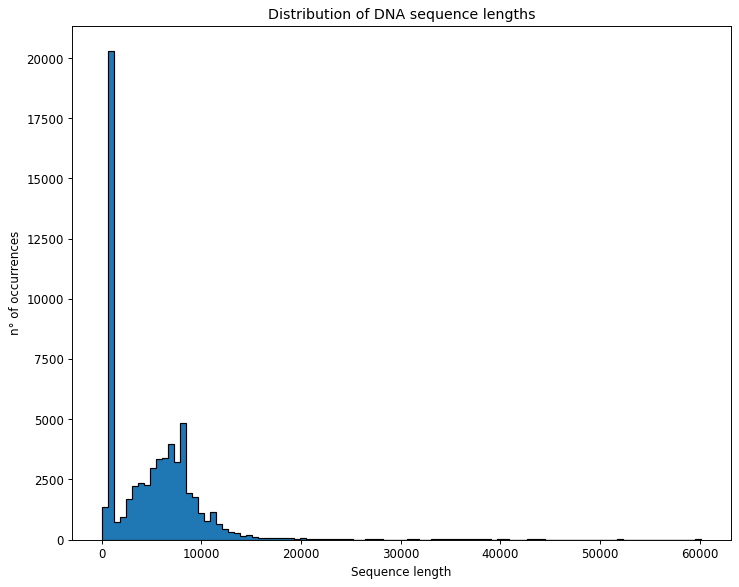

In [2]:
#sequences
Seq_length=pd.DataFrame(df.sequence.apply(len))
figure(num=None, figsize=(10, 8), dpi=85, facecolor='w', edgecolor='k')
plt.hist(Seq_length.iloc[:,0],100,histtype='stepfilled',edgecolor="k")
plt.xlabel('Sequence length')
plt.ylabel('n° of occurrences')
f=plt.title ('Distribution of DNA sequence lengths')

In [3]:
#lab
Lab_id=pd.DataFrame(Labels.idxmax(axis=1),columns=['lab_id'])
plasmid_per_lab=pd.DataFrame(Lab_id['lab_id'].value_counts().sort_values(ascending=False))
plasmid_per_lab.columns=['plasmid_per_lab']
plasmid_per_lab['Percentage']=plasmid_per_lab/df.shape[0]
plasmid_per_lab.head()

,plasmid_per_lab,Percentage
I7FXTVDP,8286,0.131488
RKJHZGDQ,2732,0.043353
GTVTUGVY,2672,0.042401
A18S09P2,1064,0.016884
Q2K8NHZY,973,0.015440


In [4]:
#split train/test
x_train, x_test, y_train, y_test = train_test_split(df, Labels, test_size=0.2, random_state=1)
#split train/val
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2 

In [11]:
print('Example of a sequence : ',x_test.sequence[3])

Example of a sequence :  GCTANGAAAAAGCCCGCTCATTAGGCGGGCTCAGATCTGCTCATGTTTGACAGCTTATCATCGATAAGCTTCGGCAATAAATTCTTGATATGTTTTCATATGTTTCCTTTAAATATTTTAATTAGTAATTGTCTATTCAAGTAATTGTGAATATACTATCACAATTCCAAGAGAAAGTAAACAGCTTTATAGATTTTTATACGCGTCCCAAGTGCCAGTTCTAAACGTTGTAATGACTCGTTTTGCGCGATTAGGTGTTTGATTATACCATCTACTTTTAGCTAAGTTAACTGCTGCTTCATCCCAGCGTTTTTGTTGAAGCATACGTAAAGAGTTAGTAAATCCTGCCACACCGGTTTCTCCCATTTGGAAAACCATATTAATCAATGCAGCGCGACGAACCGCATCAAGAGAATCATAAACCGGTTTTGCTTTAGCATTTCTCAGAATTCCGCGAACAGCAGCATCAACATCCTGATTAAAGAGTTTTTCAGCCTCATCTTTTGTAATTACACCATTAGTATTACGCCCAATAGCTTTATCTAATTCAGATTTAGCAGCATTAAGTGATGGACTTTTTGTAAGCAAATGACCGATGCCAATAGTGTAATAGCCTTCTGTGTCTTTATAGATTTTAAGTCTAAGACCTTCATCTATACGTAACATTTCAAATATATTCATAATACCTCCTAAGCATCGATGGATCCTGTTTCCTGTGTGAAATTGTTATCCGCTCACAATTCCACACATTA


# Preprocessing 

### Padding function

As the input of the neural network ought to be vectors of the same size and since the plasmid sequence lengths range from 20 to 60 099 (median value : 4741) , we have to pad the sequences, which means defining a threshold, then shorten the sequences longer than this threshold, and extend the shorter ones with random nucleoids. Function **pad_dna**




In [5]:
def pad_dna(seqs,maxlen):
    padded_seqs = [''] * len(seqs)
    for i in seqs:
        if len(i) > maxlen:
            i = i[:maxlen]
            maxlen = len(i)
    for j in range(len(seqs)):
        if len(seqs[j]) > maxlen:
            seq = seqs[j][0:maxlen]
        else:
            seq = seqs[j]
        padded_seqs[j] = seq + "N" * (maxlen - len(seq))
    return padded_seqs

### One hot encoding

The DNA sequences cannot be  fed as raw inputs to the network, we therefore need to transform them into 1hot vectors, following the arbitrary convention :<br> A = [1,0,0,0] &emsp; T =[0,1,0,0] &emsp; G =[0,0,1,0] &emsp; C =[0,0,0,1] &emsp; N =[0,0,0,0]

In [6]:
def convert_onehot2D(list_of_seqs):
    one_hot = np.zeros((len(list_of_seqs),4,len(list_of_seqs[0])))
    nt_dict = {'A':[1,0,0,0],'T':[0,1,0,0],'G':[0,0,1,0],'C':[0,0,0,1], 'N':[0,0,0,0]}
    count = 0
    for seq in list_of_seqs:
        if len(seq) > 1:
            for letter in range(len(seq)):
                for i in range(4):
                    one_hot[count][i][letter] = (nt_dict[seq[letter]])[i]
        count += 1
    return one_hot

In [9]:
#encoding sequences
max_len=500
X_train_padded=pad_dna(x_train.sequence,max_len)
X_val_padded=pad_dna(x_val.sequence,max_len)
X_test_padded=pad_dna(x_test.sequence,max_len)

#steady variables
X_train=np.transpose(convert_onehot2D(X_train_padded), axes=(0,2,1))
X_val=np.transpose(convert_onehot2D(X_val_padded), axes=(0,2,1))
X_test=np.transpose(convert_onehot2D(X_test_padded), axes=(0,2,1))

Y_train=y_train
Y_val=y_val
Y_test=y_test

In [15]:
print('X_train shape : ',X_train.shape)
print('Y_train shape : ',Y_train.shape)
print('X_test shape : ',X_test.shape)
print('Y_test shape : ',Y_test.shape)

X_train shape :  (37809, 500, 4)
Y_train shape :  (37809, 1314)
X_test shape :  (12604, 500, 4)
Y_test shape :  (12604, 1314)


### Bayesian optimization (Package details on github [here](https://github.com/fmfn/BayesianOptimization))

Bayesian Optimization is used as a way to find the optimal hyperparameters of the network. It differs from Random Search and Grid Search in that it improves the search speed using past performances, whereas the other two methods are independent of past evaluations. 

- Number of iterations: 10 <br>
- Optimization target : validation accuracy <br>
- Parameters to be optimized : n° of neurones - n° of filters - filters length


In [8]:
"""  B A Y E S I A N     O P T I M I Z A T I O N  """
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.convolutional import Convolution1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization
import time
from keras.optimizers import SGD
from keras.models import load_model 

from bayes_opt import BayesianOptimization

#network parameters:
dna_bp_length=X_train.shape[1]
num_classes=Y_train.shape[1]
min_batch_size = 8

def neural_network_target(num_dense_nodes,filter_num,filter_length):
    model = Sequential()
    model.add(Convolution1D(filters=int(filter_num),
                            kernel_size=int(filter_length),
                            activation="relu"))
    model.add(MaxPooling1D(pool_size=int(max_len-filter_length+1)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(units=num_dense_nodes))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dense(units=num_classes))
    model.add(Activation("softmax"))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=[tf.keras.metrics.TopKCategoricalAccuracy(10)])
    checkpointer = ModelCheckpoint(filepath="checkpoint.hdf5", monitor="val_acc", mode='auto', verbose=1, \
                  save_best_only=True)  
    early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, mode='auto', verbose=0)
    
    epoch=5
    history = model.fit(X_train, Y_train, batch_size = min_batch_size,
                        validation_data=(X_val, Y_val),
                        epochs=epoch, verbose=0)
    
    result=history.history['val_top_k_categorical_accuracy'][-1]

    return result


bo = BayesianOptimization(neural_network_target,
                          {'num_dense_nodes': (4,512),
                           'filter_num': (1,500),
                           'filter_length': (1,48)})

bo.maximize(n_iter=5, acq="ucb", kappa=5)
print(bo.max)

|   iter    |  target   | filter... | filter... | num_de... |
-------------------------------------------------------------
|  1        |  0.7723   |  8.29     |  452.8    |  507.6    |
|  2        |  0.6523   |  39.55    |  254.7    |  14.89    |
|  3        |  0.7553   |  25.43    |  226.3    |  297.0    |
|  4        |  0.7514   |  41.73    |  341.0    |  230.7    |
|  5        |  0.7474   |  29.88    |  138.0    |  365.8    |
|  6        |  0.3031   |  1.0      |  500.0    |  315.7    |
|  7        |  0.7731   |  8.644    |  449.9    |  511.6    |
|  8        |  0.7583   |  48.0     |  249.4    |  512.0    |
|  9        |  0.001825 |  1.0      |  4.374    |  187.1    |
|  10       |  0.5467   |  47.23    |  480.7    |  5.998    |
{'target': 0.7730879187583923, 'params': {'filter_length': 8.644309713537904, 'filter_num': 449.92334238968203, 'num_dense_nodes': 511.5587572184507}}


# 1 Dimentionnal Convolutionnal Neural Network

### Network architecture : 
<br>
<b>Input</b> -> Convolution1D -> MaxPooling -> BatchNormalization -> Flatten -> Dense(relu) -> BatchNormalization -> Dense(softmax) -> <b>Output</b>

### Network hyperparameters :
- Number of filters : 450
- Window size of filters : 8
- Number of neurons in Dense layer: 512 
- Batch Size :8
- Number of epochs : 10

### Metric : 
As the original challenge was assessing the algorithm ability to correctly place the true lab-of-origin in the top ten most likely labs predicted for each sequence, **Top10 Categorical accuracy** is to be used : `tf.keras.metrics.TopKCategoricalAccuracy(10)`
<BR>
    <BR>

In [17]:
'CNN'
#network parameters:
dna_bp_length=X_train.shape[1]
num_classes=Y_train.shape[1]

# network hyperparameters
filter_num = 130 
filter_len = 46
num_dense_nodes = 345 
epoch = 10 
min_batch_size = 8
start = time.time()

# network specification
model = Sequential()
model.add(Convolution1D(filters=filter_num,
                        kernel_size=filter_len,
                        activation="relu"))
model.add(MaxPooling1D(pool_size=max_len-filter_len+1))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(units=num_dense_nodes))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dense(units=num_classes))
model.add(Activation("softmax"))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[tf.keras.metrics.TopKCategoricalAccuracy(10)])

epoch=epoch
history = model.fit(X_train, Y_train, batch_size = min_batch_size,
                    validation_data=(X_val, Y_val),
                    epochs=epoch, verbose=1)
print('computational time :',time.time()-start,  'seconds')
print(model.summary())

Epoch 1/10
4727/4727 [==============================] - 56s 12ms/step - loss: 4.2962 - top_k_categorical_accuracy: 0.5433 - val_loss: 3.6581 - val_top_k_categorical_accuracy: 0.6358
Epoch 2/10
4727/4727 [==============================] - 56s 12ms/step - loss: 3.3013 - top_k_categorical_accuracy: 0.6682 - val_loss: 3.3066 - val_top_k_categorical_accuracy: 0.6898
Epoch 3/10
4727/4727 [==============================] - 56s 12ms/step - loss: 2.8705 - top_k_categorical_accuracy: 0.7207 - val_loss: 3.1087 - val_top_k_categorical_accuracy: 0.7198
Epoch 4/10
4727/4727 [==============================] - 56s 12ms/step - loss: 2.5814 - top_k_categorical_accuracy: 0.7585 - val_loss: 3.0658 - val_top_k_categorical_accuracy: 0.7253
Epoch 5/10
4727/4727 [==============================] - 57s 12ms/step - loss: 2.3724 - top_k_categorical_accuracy: 0.7854 - val_loss: 3.0511 - val_top_k_categorical_accuracy: 0.7353
Epoch 6/10
4727/4727 [==============================] - 56s 12ms/step - loss: 2.2130 - top

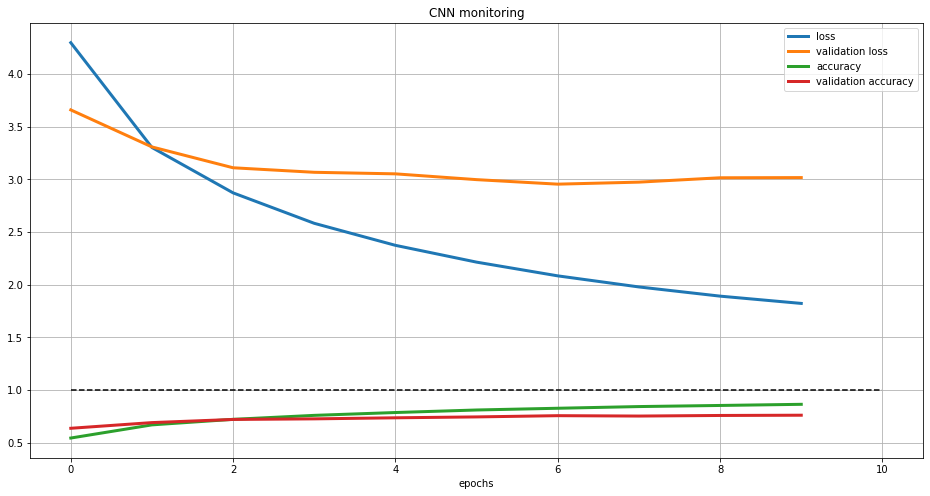

In [19]:
net=history    
loss=net.history['loss']
acc=net.history['top_k_categorical_accuracy']
validation_loss=net.history['val_loss']
validation_acc=net.history['val_top_k_categorical_accuracy']

#plot
plt.figure(figsize=(16,8))
plt.plot(loss,label='loss',linewidth=3)
plt.plot(validation_loss,label='validation loss',linewidth=3)
plt.plot(acc,label='accuracy',linewidth=3)
plt.plot(validation_acc,label='validation accuracy',linewidth=3)
plt.hlines(1,  0,epoch, colors='k', linestyles='--')
plt.legend()
plt.grid()
plt.title('CNN monitoring')
f=plt.xlabel('epochs')

In [41]:
result=model.evaluate(X_test,Y_test, verbose=0)
print('Model performance on the test set: ', result[1],'%')

Model performance on the test set:  0.764201819896698 %


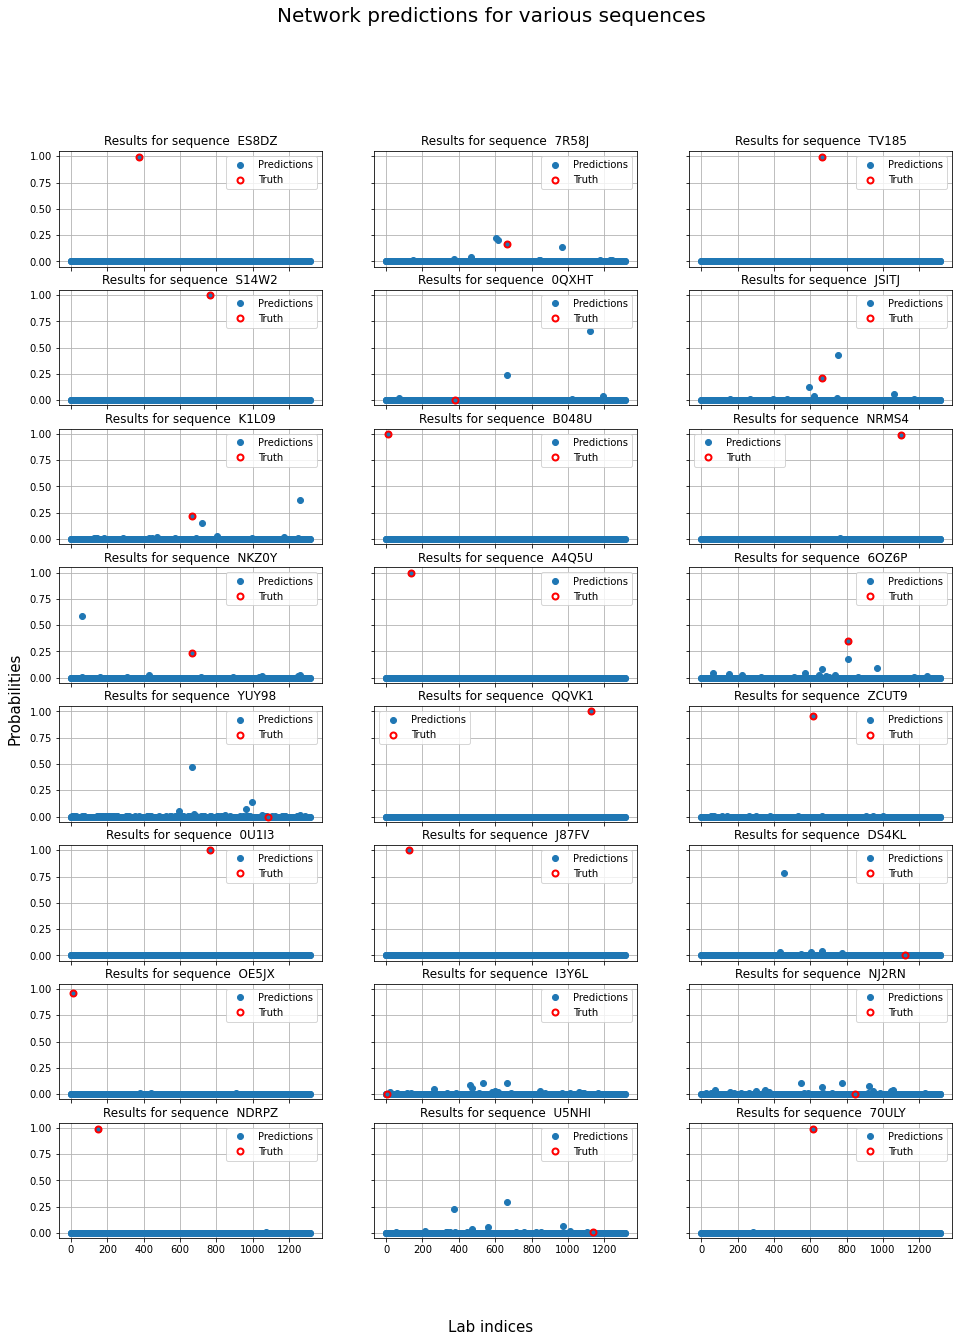

In [26]:
Pred=model.predict(X_test)
df_Pred=pd.DataFrame(Pred,columns=Y_test.columns)
Lab=pd.DataFrame(Y_test.idxmax(axis=1),columns=['lab_id'])

fig, axes = plt.subplots(8,3, sharex=True, sharey=True,figsize=(16,20))
for i, ax in enumerate(axes.flatten()):
    C=Lab.iloc[i].values[0]
    xx=df_Pred.columns.get_loc(C)
    yy=df_Pred[C][i]
    ax.plot(Pred[i,:],'o',label="Predictions")
    ax.plot(xx,yy,'or',mew=2,mfc="None",label='Truth')
    ax.legend()
    ax.grid()
    ax.title.set_text('Results for sequence  '+str(Lab.index[i]))

fig.text(0.5, 0.06, 'Lab indices', ha='center',fontsize=15)
fig.text(0.08, 0.5, 'Probability distribution for each lab', va='center',fontsize=15, rotation='vertical')
f=fig.suptitle("Network predictions for various sequences", fontsize=20)

# Discussion

**Model is achieving 0.76% accuracy**<br><br>
This result is similar to [altLabs BLAST benchmark](https://altlabs.tech/geac/blast-benchmark/), common reference for general plasmid attribution tasks

The previous plot is showing the network predictions for various DNA sequences as a serie of probabilities, one for each of the 1314 laboratories.<br> For each sequences, the vast majority of labs has an extremely low probability of being at the origin of the plasmid, while one or a few labs stand out as being possible candidates. 

In unambiguous situations when only one lab is associated with a non zero probability, the model is rarely mistaken (Truth matches with the highest  probability prediction).<br>
In ambiguous situations, the model often gets it wrong, hence questionning the relevance of the top10 accuracy metric (results would have been substantially similar if only the most probable lab was used to calculate the accuracy).
<br><br><br><br>

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;**R. GILLET**